# Explore U19 data Pipeline

Here we introduce some useful DataJoint tools to explore the U19 pipeline

First thing first, import datajoint

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


# 1. Browse schemas you have access to - `dj.list_schemas()`

In [2]:
import datajoint as dj
import pandas as pd
import subprocess
import utility.path_utility as pu
import matplotlib.pyplot as plt
import pathlib


## Major schemas:   

Meta data: `u19_lab`, `u19_subject`, `u19_action`, `u19_task`  
Behavior: `u19_acquisition`, `u19_behavior` (also contains some imaging info)

These schemas have been generated by matlab or python, but as a user, you don't have to get the code to generate these tables. To work with these tables, the simplest thing you would do is to reconstruct a module that represents this schema with the method `create_virtual_module`.

In [16]:
acquisition = dj.create_virtual_module('acquisition', 'bl_new_acquisition')
df_ephys = pd.DataFrame((acquisition.AcquisitionSessions * acquisition.Sessions.proj('sessid', 'session_date')).fetch(as_dict=True))
df_ephys

,sessid,session_rat,session_userid,session_rigid,acquisition_type,acquisition_raw_rel_path,acquisition_post_rel_path,session_date
0,585444,T170,zhihaol,202,ephys,Thomas/T170/T170_2018_03_16,Thomas/T170/T170_2018_03_16_600s/spikesort_202...,2018-03-16
1,585488,T173,zhihaol,202,ephys,Thomas/T173/T173_bank1_2018_03_16,Thomas/T173/T173_2018_03_16_bank1_600s/spikeso...,2018-03-16
2,586335,T170,zhihaol,202,ephys,Thomas/T170/T170_2018_03_19,Thomas/T170/T170_2018_03_19/spikesort_2020_09_...,2018-03-19
3,586376,T173,zhihaol,202,ephys,Thomas/T173/T173_bank0_2018_03_19,Thomas/T173/T173_2018_03_19_bank0_600s/spikeso...,2018-03-19
4,590577,T170,zhihaol,202,ephys,Thomas/T170/T170_2018_04_05,Thomas/T170/T170_2018_04_05/spikesort_2020_09_...,2018-04-05
...,...,...,...,...,...,...,...,...
282,798430,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_13c_g0,Thomas/T274/T274_2020_12_13c/spikesort_2020_12...,2020-12-13
283,798586,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_14_g0,Thomas/T274/T274_2020_12_14/spikesort_2020_12_...,2020-12-14
284,798742,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_15_g0,Thomas/T274/T274_2020_12_15/spikesort_2020_12_...,2020-12-15
285,798897,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_16_g0,Thomas/T274/T274_2020_12_16/spikesort_2020_12_...,2020-12-16


In [20]:
#for i in range(df_imaging.shape[0])
df_ephys['size_raw_TB'] = df_ephys.apply(lambda x: pu.get_size_directory2(str(pathlib.Path(dj.config['custom']['ephys_root_data_dir'][0],x['acquisition_raw_rel_path']))),axis=1)
df_ephys['size_raw_TB'] = df_ephys['size_raw_TB']/(1024*1024*1024*1024)
df_ephys['size_sorted_TB'] = df_ephys.apply(lambda x: pu.get_size_directory2(str(pathlib.Path(dj.config['custom']['ephys_root_data_dir'][1],x['acquisition_post_rel_path']))),axis=1)
df_ephys['size_sorted_TB'] = df_ephys['size_sorted_TB']/(1024*1024*1024*1024)
df_ephys['size_TB'] = df_ephys['size_raw_TB'] + df_ephys['size_sorted_TB']

In [21]:
df_ephys['session_date'] = df_ephys['session_date'].astype('str')
df_ephys['year'] = df_ephys['session_date'].str.slice(0,4).astype('int')

In [22]:
df_ephys.describe()

,sessid,session_rigid,size_raw_TB,size_sorted_TB,year,size_TB
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,710350.324042,201.355401,0.263676,0.058001,2018.989547,0.321678
std,73871.627517,16.081496,0.073988,0.043518,0.829880,0.097985
min,585444.000000,2.000000,0.005194,0.000067,2018.000000,0.008122
25%,625648.000000,202.000000,0.226462,0.022563,2018.000000,0.261191
50%,743260.000000,202.000000,0.264240,0.052396,2019.000000,0.325793
75%,785071.500000,202.000000,0.303623,0.084089,2020.000000,0.383184
max,798899.000000,205.000000,0.516410,0.287991,2020.000000,0.599050


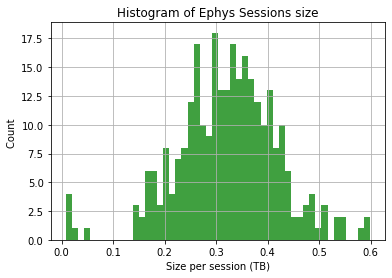

In [48]:
n, bins, patches = plt.hist(df_ephys['size_TB'].values , 50, facecolor='g', alpha=0.75)
plt.xlabel('Size per session (TB)')
plt.ylabel('Count ')
plt.title('Histogram of Ephys Sessions size')
plt.grid(True)
plt.show()

In [34]:
# same as above
df_ephys[["session_userid", "size_TB"]].groupby(by=["session_userid"]).sum()

,size_TB
session_userid,
abondy,16.896409
dikshag,3.955341
zhihaol,71.469705


In [47]:
df_ephys[["session_userid", "size_TB"]].groupby(by=["session_userid"]).mean()

,size_TB
session_userid,
abondy,0.286380
dikshag,0.329612
zhihaol,0.330878


The tables could be from different schemas:

In [44]:
df_ephys_pre = pd.DataFrame((acquisition.PreAcquisitionSessions * acquisition.Sessions.proj('sessid', 'session_date')).fetch(as_dict=True))
df_ephys_pre = df_ephys_pre.drop_duplicates(subset = ['sessid'], keep = 'first') 
df_ephys_pre = df_ephys_pre.reset_index(drop=True)
df_ephys_pre['session_date'] = df_ephys_pre['session_date'].astype('str')
df_ephys_pre['year'] = df_ephys_pre['session_date'].str.slice(0,4).astype('int')
df_ephys_pre

,sessid,directory_num,session_rat,session_userid,session_rigid,acquisition_type,acquisition_raw_rel_path,acquisition_post_rel_path,correct_dirs,session_date,year
0,585444,0,T170,zhihaol,202,ephys,Thomas/T170/T170_2018_03_16,Thomas/T170/T170_2018_03_16_600s/spikesort_202...,1,2018-03-16,2018
1,585488,0,T173,zhihaol,202,ephys,Thomas/T173/T173_bank1_2018_03_16,Thomas/T173/T173_2018_03_16_bank1_600s/spikeso...,1,2018-03-16,2018
2,586335,0,T170,zhihaol,202,ephys,Thomas/T170/T170_2018_03_19,Thomas/T170/T170_2018_03_19/spikesort_2020_09_...,1,2018-03-19,2018
3,586376,0,T173,zhihaol,202,ephys,Thomas/T173/T173_bank0_2018_03_19,Thomas/T173/T173_2018_03_19_bank0_600s/spikeso...,1,2018-03-19,2018
4,590577,0,T170,zhihaol,202,ephys,Thomas/T170/T170_2018_04_05,Thomas/T170/T170_2018_04_05/spikesort_2020_09_...,1,2018-04-05,2018
...,...,...,...,...,...,...,...,...,...,...,...
429,798430,0,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_13c_g0,Thomas/T274/T274_2020_12_13c/spikesort_2020_12...,1,2020-12-13,2020
430,798586,0,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_14_g0,Thomas/T274/T274_2020_12_14/spikesort_2020_12_...,1,2020-12-14,2020
431,798742,0,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_15_g0,Thomas/T274/T274_2020_12_15/spikesort_2020_12_...,1,2020-12-15,2020
432,798897,0,T274,zhihaol,202,ephys,Thomas/T274/T274_2020_12_16_g0,Thomas/T274/T274_2020_12_16/spikesort_2020_12_...,1,2020-12-16,2020


In [45]:
df_ephys_pre[["session_userid", "acquisition_type"]].groupby(by=["session_userid"]).count()

,acquisition_type
session_userid,
abondy,100
dikshag,21
zhihaol,313


In [46]:
df_ephys_pre[["session_userid", "acquisition_type", "year"]].groupby(by=["session_userid", "year"]).count()

acquisition_type
session_userid year                  
abondy         2019                55
               2020                45
dikshag        2019                 8
               2020                13
zhihaol        2018               132
               2019                89
               2020                92